In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
fifa = pd.read_csv("fifa_ranking.csv")

In [3]:
fifa.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [4]:
len(fifa['country_full'].unique())

216

In [5]:
def make_soup(url):
    thepage=urllib.request.urlopen(url)
    soupdata=BeautifulSoup(thepage, "html.parser")
    return soupdata

In [6]:
soup = make_soup("https://en.wikipedia.org/wiki/List_of_countries_by_past_and_projected_GDP_(nominal)")

In [7]:
def create_csv(table):
    countries_data_saved = ""
    for record in table.findAll('tr'):
        countries_data = ""
        for data in record.findAll('th'):
            countries_data = countries_data + "_" + data.text
        for data in record.findAll('td'):
            countries_data = countries_data + "_" + data.text
        countries_data_saved = countries_data_saved + countries_data[1:]

    countries_data_saved = countries_data_saved.replace(",", "")
    countries_data_saved = countries_data_saved.replace("\xa0", "")
    countries_data_saved = countries_data_saved.replace("_", ",")
    
    return countries_data_saved
    

tables = soup.find_all('table', class_="wikitable")
csv1 = create_csv(tables[1])
countries_1 = pd.read_csv(StringIO(csv1))

csv2 = create_csv(tables[3])
countries_2 = pd.read_csv(StringIO(csv2))

csv3 = create_csv(tables[5])
countries_3 = pd.read_csv(StringIO(csv3))

csv4 = create_csv(tables[7])
countries_4 = pd.read_csv(StringIO(csv4))

In [8]:
countries = pd.merge(countries_1.drop_duplicates(), countries_2.drop_duplicates(), on='Country (or dependent territory)', validate="one_to_one", how="inner")
countries = pd.merge(countries, countries_3.drop_duplicates(), on='Country (or dependent territory)', validate="one_to_one", how="inner")
countries = pd.merge(countries, countries_4.drop_duplicates(subset='Country (or dependent territory)', keep="last"), on='Country (or dependent territory)', validate="one_to_one", how="inner")

countries = pd.melt(countries, id_vars=['Country (or dependent territory)'], var_name='year', value_name='gdp')
countries.columns = ["country", "year", "gdp"]

In [9]:
fifa.rank_date = fifa.rank_date.apply(lambda x: re.sub(r'-[0-9]{2}-[0-9]{2}', "", x))
fifa.rank_date = fifa.rank_date.astype(int)
countries.year = countries.year.astype(int)

In [10]:
countries = countries[(countries.year >= 1993) & (countries.year <= 2018)]

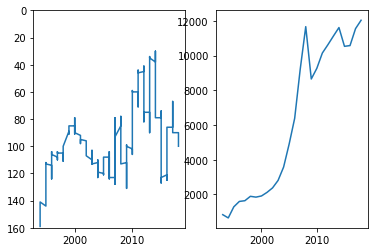

In [11]:
armenia = fifa[fifa.country_full == "Armenia"]
armenia.dtypes
arm_gdp = countries[countries["country"] == "Armenia"]
plt.subplot(1, 2, 1)
plt.plot(armenia['rank_date'], armenia['rank'])
plt.ylim(160, 0)
plt.subplot(1, 2, 2)
plt.plot(arm_gdp["year"].astype(int), arm_gdp["gdp"].astype(int))
plt.show()

In [12]:
fifa = fifa.groupby(['rank_date', "country_full"], as_index=False)['rank'].mean()
fifa.columns.values[1] = 'country'
fifa.columns.values[0] = 'year'

In [13]:
fifa.dtypes

year         int64
country     object
rank       float64
dtype: object

In [14]:
countries.dtypes

country     object
year         int64
gdp        float64
dtype: object

In [15]:
combined = fifa.merge(countries, on=["country", "year"], how='left', indicator=True, validate='one_to_one')
fifa = fifa[combined['_merge'] == 'both']

In [16]:
countries

,country,year,gdp
2522,Afghanistan,1993,NaN
2523,Albania,1993,1461.0
2524,Algeria,1993,50963.0
2525,Angola,1993,6095.0
2526,Antigua and Barbuda,1993,535.0
2527,Argentina,1993,256365.0
2528,Armenia,1993,835.0
2529,Australia,1993,309639.0
2530,Austria,1993,189958.0
2531,Azerbaijan,1993,1309.0


In [17]:
combined = countries.merge(fifa, on=["country", "year"], how='left', indicator=True, validate='one_to_one')
countries.reset_index(inplace=True, col_fill=False)
countries = countries[combined['_merge'] == 'both']

In [18]:
combined['_merge'] == 'both'

0       False
1        True
2        True
3        True
4        True
5        True
6       False
7        True
8        True
9       False
10       True
11       True
12       True
13       True
14       True
15       True
16      False
17       True
18      False
19       True
20      False
21       True
22       True
23      False
24       True
25       True
26       True
27      False
28      False
29       True
        ...  
5014     True
5015     True
5016     True
5017     True
5018     True
5019    False
5020     True
5021     True
5022     True
5023     True
5024     True
5025     True
5026     True
5027     True
5028     True
5029     True
5030    False
5031     True
5032     True
5033     True
5034    False
5035    False
5036     True
5037     True
5038     True
5039     True
5040     True
5041     True
5042     True
5043     True
Name: _merge, Length: 5044, dtype: bool

In [19]:
fifa.to_csv("fifa_ranking_preprocessed.csv")
countries.to_csv("gdp_preprocessed.csv")

In [20]:
countries

,index,country,year,gdp
1,2523,Albania,1993,1461.0
2,2524,Algeria,1993,50963.0
3,2525,Angola,1993,6095.0
4,2526,Antigua and Barbuda,1993,535.0
5,2527,Argentina,1993,256365.0
7,2529,Australia,1993,309639.0
8,2530,Austria,1993,189958.0
10,2532,Bahamas,1993,5097.0
11,2533,Bahrain,1993,5985.0
12,2534,Bangladesh,1993,38234.0
